Fruits and Vegetables Classification


In [3]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from PIL import Image



In [4]:
ORIG_DATASET_DIR = "/Users/karlap/Documents/Universidad/dataset"
TARGET_DIR = "/Users/karlap/Documents/Universidad/dataset_dividido"

train_split = 0.70
val_split = 0.10
test_split = 0.20

random.seed(42)

for folder_name in os.listdir(ORIG_DATASET_DIR):
    folder_path = os.path.join(ORIG_DATASET_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    if '_' not in folder_name:
        continue

    fruit, condition = folder_name.split('_', 1)  
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not images:
        continue
    
    random.shuffle(images)
    total = len(images)
    train_end = int(train_split * total)
    val_end = train_end + int(val_split * total)


    subsets = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for subset, files in subsets.items():
        dest_dir = os.path.join(TARGET_DIR, subset, folder_name)
        os.makedirs(dest_dir, exist_ok=True)
        for file in files:
            src_file = os.path.join(folder_path, file)
            dest_file = os.path.join(dest_dir, file)
            try:
                with Image.open(src_file) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img.save(dest_file)
            except Exception as e:
                print(f"Error procesando {src_file}: {e}")


/Users/karlap/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
train_dir = os.path.join(TARGET_DIR, "train")
val_dir = os.path.join(TARGET_DIR, "val")
test_dir = os.path.join(TARGET_DIR, "test")

train_datagen = ImageDataGenerator (
    rescale = 1./255,
    rotation_range = 20, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (224, 224),
	batch_size = 32,
	class_mode ='categorical',
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 20484 images belonging to 28 classes.
Found 2917 images belonging to 28 classes.
Found 5876 images belonging to 28 classes.


Red neuronal convolutiva 


In [6]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    include_preprocessing=True 
)
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
outputs = tf.keras.layers.Dense(test_generator.num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │        35,868 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,955,180 (22.72 MB)

 Trainable params: 5,894,572 (22.49 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
)

/Users/karlap/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - accuracy: 0.6086 - loss: 1.5459 - val_accuracy: 0.9126 - val_loss: 0.3206
Epoch 2/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 1255s 2s/step - accuracy: 0.9330 - loss: 0.2321 - val_accuracy: 0.7816 - val_loss: 0.7678
Epoch 3/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 1185s 2s/step - accuracy: 0.9604 - loss: 0.1334 - val_accuracy: 0.8241 - val_loss: 0.5590
Epoch 4/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.9725 - loss: 0.0920 - val_accuracy: 0.5821 - val_loss: 1.5455
Epoch 5/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 1213s 2s/step - accuracy: 0.9803 - loss: 0.0675 - val_accuracy: 0.6226 - val_loss: 1.4352


In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc: \n', test_acc)
print('\ntest loss: \n', test_loss)

/Users/karlap/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 58s 317ms/step - accuracy: 0.6073 - loss: 1.4708

test acc: 
 0.6113002300262451

test loss: 
 1.4573335647583008


Evaluación del Modelo

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Obtener todas las imágenes y etiquetas del generador de prueba
test_images = []
test_labels = []

for i in range(len(test_generator)):
    imgs, labels = test_generator[i]
    test_images.extend(imgs)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = np.argmax(test_labels, axis=1)

# Predicciones del modelo
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step


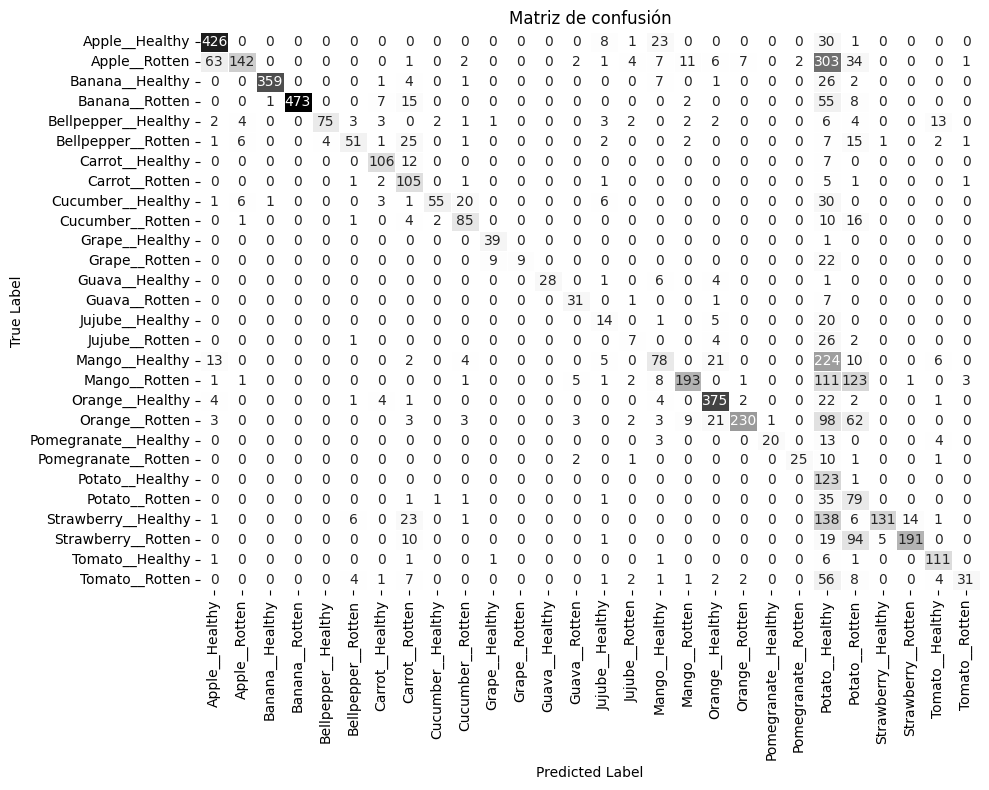

In [10]:
import seaborn as sns
# Calcular la matriz de confusión
mat = confusion_matrix(test_labels, predicted_classes)

# Obtener nombres de clases
class_names = [None] * len(test_generator.class_indices)
for name, index in test_generator.class_indices.items():
    class_names[index] = name

# Mostrar matriz de confusión clara y legible
plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names, linewidths=0.7, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

In [11]:
# Calcular métricas
accuracy = accuracy_score(test_labels, predicted_classes)
precision = precision_score(test_labels, predicted_classes, average='macro')
recall = recall_score(test_labels, predicted_classes, average='macro')
f1 = f1_score(test_labels, predicted_classes, average='macro')

# Métricas
print("\n--- MÉTRICAS  ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



--- MÉTRICAS  ---
Accuracy:  0.6113
Precision: 0.7618
Recall:    0.6081
F1 Score:  0.6182


Guardar el modelo

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
%cd "/Users/karlap/Documents/Universidad/SavingModel"
!mkdir "save_model"
model.save("save_model/mi_modelo.keras")

/Users/karlap/Documents/Universidad/SavingModel
mkdir: save_model: File exists
